# TGCN model - static approach - Crypto Market

## Import libraries

In [10]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tools.SP100Stock import SP100Stocks
from models import TGCN, train

## Preprocessing

In [11]:
def future_close_price_to_buy_sell_class(sample: Data, threshold: float = 0.01):
	"""
	Transforms the target y to a three-class classification:
	- Down (0): return < -threshold
	- Neutral (1): -threshold <= return <= threshold
	- Up (2): return > threshold
	:param sample: Data sample
	:param threshold: Threshold for categorizing returns (default: 0.01 = 1%)
	:return: The transformed sample
	"""
	market_return = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).mean()
	sample.returns = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).unsqueeze(1)
	sample.market_return = market_return
	
	# Create three-class labels: 0=Down, 1=Neutral, 2=Up
	sample.y = torch.zeros_like(sample.returns, dtype=torch.long).squeeze(1)
	sample.y[sample.returns.squeeze(1) < -threshold] = 0  # Down
	sample.y[(sample.returns.squeeze(1) >= -threshold) & (sample.returns.squeeze(1) <= threshold)] = 1  # Neutral
	sample.y[sample.returns.squeeze(1) > threshold] = 2  # Up
	
	return sample

In [12]:
from functools import partial

weeks_ahead = 1
threshold = 0.0055  # 1% threshold for neutral zone

# Create a partial function with the threshold parameter
transform_with_threshold = partial(future_close_price_to_buy_sell_class, threshold=threshold)

dataset_pearson = SP100Stocks(root="../data/",values_file_name='values_crypto.csv' ,adj_file_name='pearson_adj_crypto.npy', future_window=weeks_ahead, force_reload=True, transform=transform_with_threshold)
dataset_pearson, dataset_pearson[0]

Processing...


Loading and processing data for PyG format...
Values DataFrame shape: (52141, 14)
Values index levels: ['Symbol', 'Date']
Unique symbols in values: 50
Adjacency matrix shape: (50, 50)
Number of nodes (from adj): 50
Number of edges: 2252
Unique symbols count: 50
Unique dates count: 1058

Pivoting data to align stocks and timestamps...
Feature columns (excluding Close): 13
Features: ['SimpleReturn', 'LogReturn', 'Ret_1W', 'Ret_2W', 'Ret_1M', 'Ret_2M', 'Norm_Ret', 'RSI', 'MACD', 'Intraday_Volatility', 'Intraday_Momentum', 'Upper_Shadow_Ratio', 'Lower_Shadow_Ratio']
Pivoted shape (Date x Symbol): (1058, 50)

Final array shapes:
  x (features): (50, 1058, 13)
  close_prices: (50, 1058)
  Expected x shape: (nodes_nb=50, timestamps_nb=1058, features_nb=13)
  After transpose: x shape = torch.Size([50, 13, 1058])
  Expected: (nodes_nb=50, features_nb=13, timestamps_nb=1058)

Building edge index and edge weights...
  Created 2252 edges



Done!


(SP100Stocks(1032),
 Data(x=[50, 13, 25], edge_index=[2, 2252], y=[50], edge_weight=[2252], close_price=[50, 25], close_price_y=[50, 1], returns=[50, 1], market_return=-0.039752718061208725))

In [13]:
train_part = .9
batch_size = 32

train_dataset_pearson, test_dataset_pearson = dataset_pearson[:int(train_part * len(dataset_pearson))], dataset_pearson[int(train_part * len(dataset_pearson)):]
print(f"Train dataset_pearson: {len(train_dataset_pearson)}, Test dataset_pearson: {len(test_dataset_pearson)}")
train_dataloader_pearson, test_dataloader_pearson = DataLoader(train_dataset_pearson, batch_size=batch_size, shuffle=True), DataLoader(test_dataset_pearson, batch_size=len(test_dataset_pearson), shuffle=True)

Train dataset_pearson: 928, Test dataset_pearson: 104


## Model set up

### Pearson graph approach

In [14]:
in_channels, out_channels, hidden_size, layers_nb, dropout = dataset_pearson[0].x.shape[-2], 3, 16, 2, .3  # 3 classes: Down, Neutral, Up
model = TGCN(in_channels, out_channels, hidden_size, layers_nb,use_gat=True)

lr, weight_decay, num_epochs = 0.005, 1e-5, 100
	
# Use CrossEntropyLoss for multi-class classification (3 classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(13, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=45, out_features=16, bias=True)
      (lin_r): Linear(in_features=45, out_features=16, bias=True)
      (lin_c): Linear(in_features=45, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
    (1): Identity()
  )
)

In [15]:

# Set device to CUDA
device = torch.device('cuda')
print(f"Using device: {device}")

model = model.to(device)
criterion = criterion.to(device)

Using device: cuda


In [16]:
train(model, optimizer, criterion, train_dataloader_pearson, test_dataloader_pearson, num_epochs, "UpDownTrend_pearson_crypto", measure_acc=True)

Epochs: 100%|██████████| 100/100 [22:55<00:00, 13.75s/it, Batch=100.0%]


([1.0570524458227486,
  1.027713617374157,
  1.022975352303735,
  1.0200183720424258,
  1.0128209220952,
  1.0076743528760712,
  1.0024003489264126,
  1.0002888975472286,
  0.998719309938365,
  0.99607096047237,
  0.9948855412417444,
  0.9944394806335712,
  0.9945644736289978,
  0.9923189076884039,
  0.9893899457208042,
  0.9907121946071756,
  0.985377876923002,
  0.9797668559797879,
  0.9776979520403105,
  0.9775234275850756,
  0.967830177011161,
  0.9773814410998903,
  0.9659206702791411,
  0.9542940402853077,
  0.9526570665425268,
  0.9470245057138903,
  0.9449851348482329,
  0.9384351126078901,
  0.9298111015352709,
  0.9217394055991337,
  0.9235022725730107,
  0.9128898299973587,
  0.90480454214688,
  0.8972274599404171,
  0.8875634444170984,
  0.893580958761018,
  0.8768030158404646,
  0.8694003882079289,
  0.8757741718456663,
  0.8551832396408607,
  0.8460196708810741,
  0.843464156676983,
  0.8377857454891863,
  0.8225362547512712,
  0.8251520621365515,
  0.8156599525747628,
  

In [17]:
from datetime import datetime

# Generate timestamp for model filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"../runs/tgcn_pearson_crypto_{model.__class__.__name__}_{timestamp}.pt"

# Save model
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../runs/tgcn_pearson_crypto_TGCN_20260123_195900.pt


#### Visualization

Plot saved to: ../runs/tgcn_pearson_crypto_TGCN_20260123_195900_predictions.png


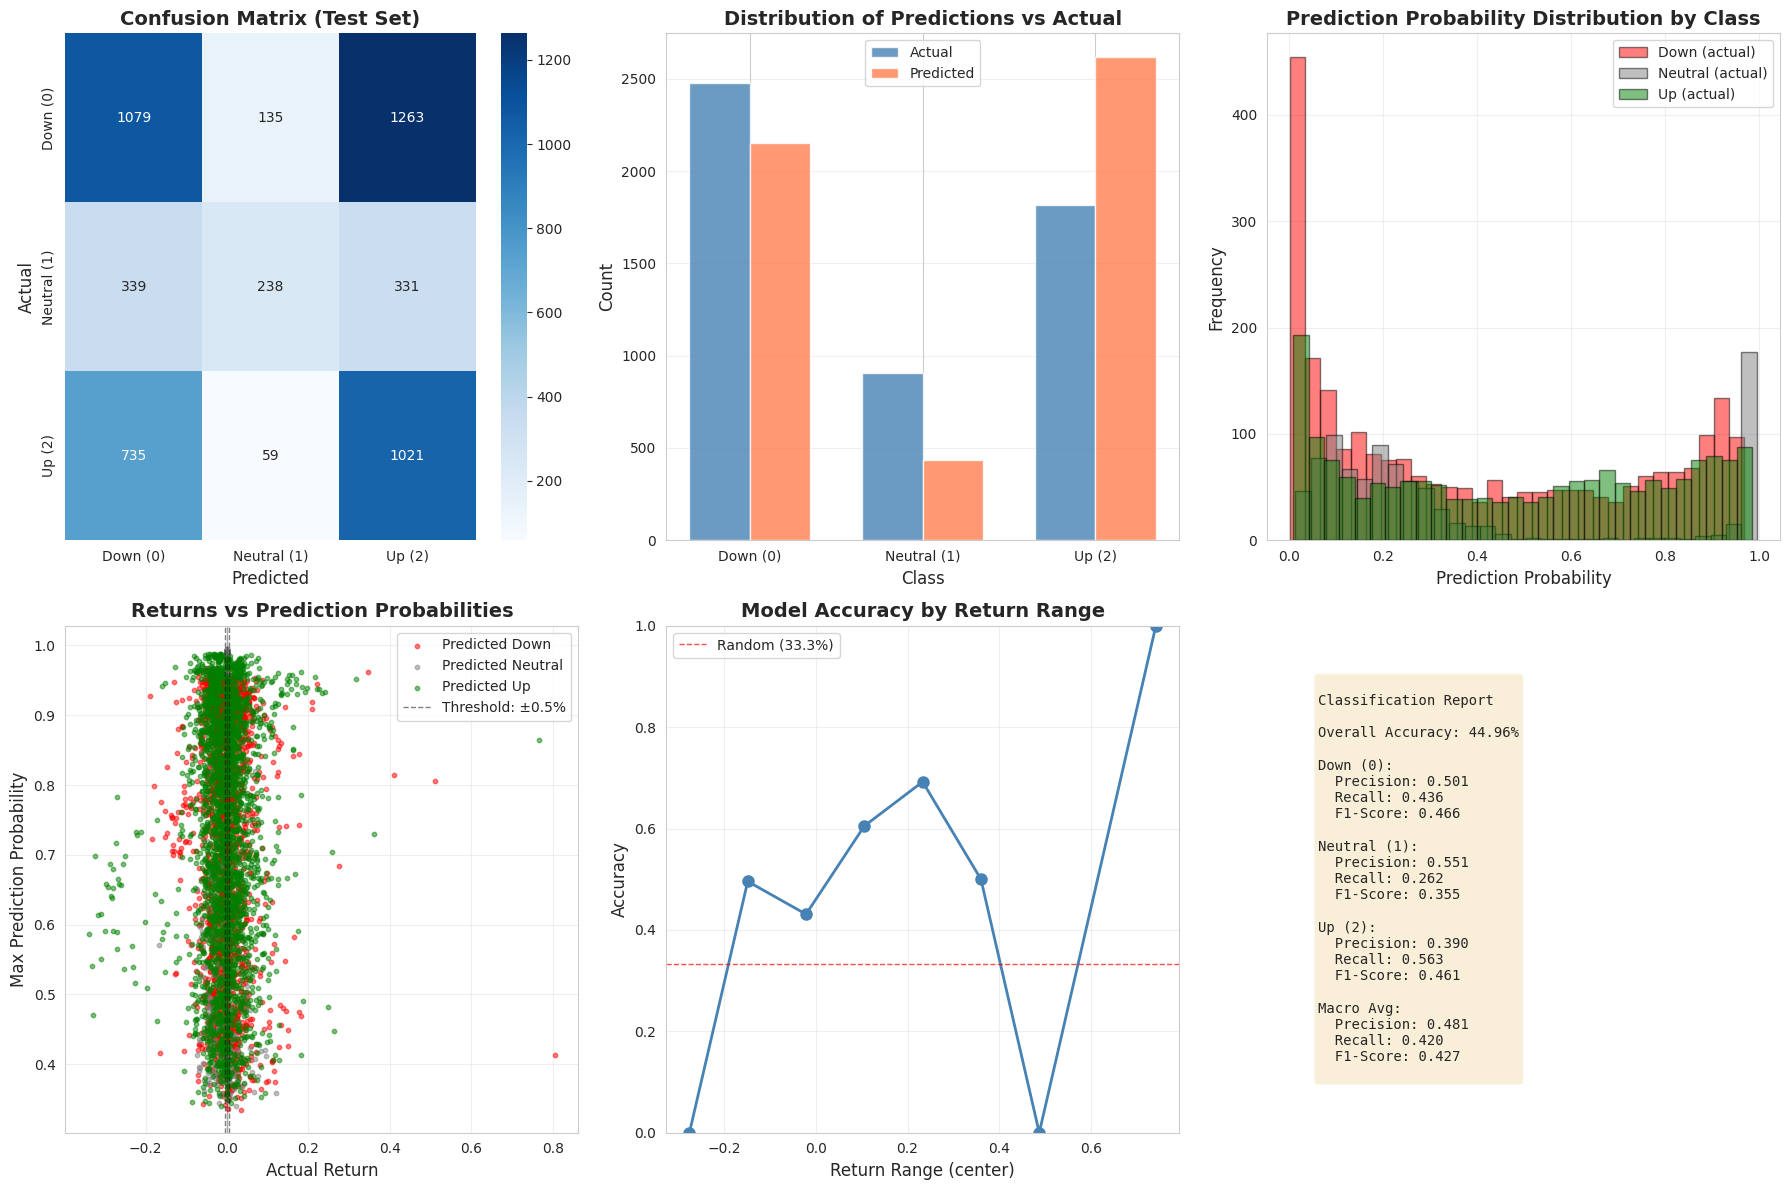


PREDICTION VISUALIZATION SUMMARY
Total predictions: 5200
Overall accuracy: 44.96%

Class Distribution (Actual):
  Down (0):    2477 (47.63%)
  Neutral (1):   908 (17.46%)
  Up (2):      1815 (34.90%)

Class Distribution (Predicted):
  Down (0):    2153 (41.40%)
  Neutral (1):   432 ( 8.31%)
  Up (2):      2615 (50.29%)

Average max prediction probability: 0.719
Average actual return: -0.0040 (-0.40%)
Threshold used: ±0.55%



In [18]:
from visualization import plot_model_predictions

# Visualize model predictions on test set and save the plot
plot_model_predictions(model, test_dataloader_pearson, device, threshold, save_path=model_path)